In [1]:
import sys
sys.path.append('/notebooks/models/research/slim/')

In [2]:
import argparse
import os
import numpy as np
try:
    import better_exceptions
except ImportError:
    pass
import tensorflow as tf
from src.model import crnn_fn
from src.data_handler import make_input_fn
from src.data_handler import preprocess_image_for_prediction

from src.config import Params, import_params_from_json

### Custom CNN

In [3]:
def deep_cnn(input_imgs: tf.Tensor, is_training=False, summaries=False):
    
    input_tensor = input_imgs
    if input_tensor.shape[-1] == 1:
        input_channels = 1
    elif input_tensor.shape[-1] == 3:
        input_channels = 3
    else:
        raise NotImplementedError

    # Following source code, not paper

    with tf.variable_scope('deep_cnn'):
        # - conv1 - maxPool2x2
        with tf.variable_scope('layer1'):
            W = weightVar([3, 3, input_channels, 64])
            b = biasVar([64])
            conv = conv2d(input_tensor, W, name='conv')
            out = tf.nn.bias_add(conv, b)
            conv1 = tf.nn.relu(out)
            pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='SAME', name='pool')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer1/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer1/bias:0'][0]
                tf.summary.histogram('bias', bias)


        # - conv2 - maxPool 2x2
        with tf.variable_scope('layer2'):
            W = weightVar([3, 3, 64, 128])
            b = biasVar([128])
            conv = conv2d(pool1, W)
            out = tf.nn.bias_add(conv, b)
            conv2 = tf.nn.relu(out)
            pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], strides=[1, 2, 2, 1],
                                   padding='SAME', name='pool1')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer2/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer2/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv3 - w/batch-norm (as source code, not paper)
        with tf.variable_scope('layer3'):
            W = weightVar([3, 3, 128, 256])
            b = biasVar([256])
            conv = conv2d(pool2, W)
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv3 = tf.nn.relu(b_norm, name='ReLU')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer3/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer3/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv4 - maxPool 2x1
        with tf.variable_scope('layer4'):
            W = weightVar([3, 3, 256, 256])
            b = biasVar([256])
            conv = conv2d(conv3, W)
            out = tf.nn.bias_add(conv, b)
            conv4 = tf.nn.relu(out)
            pool4 = tf.nn.max_pool(conv4, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                                   padding='SAME', name='pool4')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer4/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer4/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv5 - w/batch-norm
        with tf.variable_scope('layer5'):
            W = weightVar([3, 3, 256, 512])
            b = biasVar([512])
            conv = conv2d(pool4, W)
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv5 = tf.nn.relu(b_norm)

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer5/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer5/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv6 - maxPool 2x1 (as source code, not paper)
        with tf.variable_scope('layer6'):
            W = weightVar([3, 3, 512, 512])
            b = biasVar([512])
            conv = conv2d(conv5, W)
            out = tf.nn.bias_add(conv, b)
            conv6 = tf.nn.relu(out)
            pool6 = tf.nn.max_pool(conv6, [1, 2, 2, 1], strides=[1, 2, 1, 1],
                                   padding='SAME', name='pool6')

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer6/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer6/bias:0'][0]
                tf.summary.histogram('bias', bias)

        # - conv 7 - w/batch-norm (as source code, not paper)
        with tf.variable_scope('layer7'):
            W = weightVar([2, 2, 512, 512])
            b = biasVar([512])
            conv = conv2d(pool6, W, padding='VALID')
            out = tf.nn.bias_add(conv, b)
            b_norm = tf.layers.batch_normalization(out, axis=-1,
                                                   training=is_training, name='batch-norm')
            conv7 = tf.nn.relu(b_norm)

            if summaries:
                weights = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer7/weights:0'][0]
                tf.summary.histogram('weights', weights)
                bias = [var for var in tf.global_variables() if var.name == 'deep_cnn/layer7/bias:0'][0]
                tf.summary.histogram('bias', bias)

        cnn_net = conv7

        with tf.variable_scope('Reshaping_cnn'):
            shape = cnn_net.get_shape().as_list()  # [batch, height, width, features]
            transposed = tf.transpose(cnn_net, perm=[0, 2, 1, 3],
                                      name='transposed')  # [batch, width, height, features]
            conv_reshaped = tf.reshape(transposed, [shape[0], -1, shape[1] * shape[3]],
                                       name='reshaped')  # [batch, width, height x features]

    return conv_reshaped

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
cp /notebooks/samples/0.png /tmp

In [67]:
from skimage import io, transform

def resize_img(img):
    return transform.rescale(img, 384 / img.shape[1], mode='constant', cval=255, clip=True, preserve_range=True)

(32, 256)
(1, 48, 384, 1)


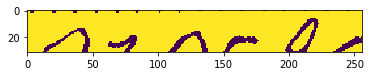

In [69]:
img = cv2.imread('/tmp/0.png', 0)[:32,:256]
plt.imshow(img)

print(img.shape)
img = resize_img(img).reshape(1,-1,384,1)
# img = img.reshape(1,32,-1,1).astype(np.float32)


print(img.shape)

In [8]:
def weightVar(shape, mean=0.0, stddev=0.02, name='weights'):
    init_w = tf.truncated_normal(shape=shape, mean=mean, stddev=stddev)
    return tf.Variable(init_w, name=name)


def biasVar(shape, value=0.0, name='bias'):
    init_b = tf.constant(value=value, shape=shape)
    return tf.Variable(init_b, name=name)


def conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME', name=None):
    return tf.nn.conv2d(input, filter, strides=strides, padding=padding, name=name)

In [9]:
with tf.Graph().as_default():
    conv = deep_cnn(img.astype(np.float32))

In [10]:
conv

<tf.Tensor 'deep_cnn/Reshaping_cnn/reshaped:0' shape=(1, 31, 512) dtype=float32>

### Resnet-101 

In [12]:
from nets.resnet_v1 import resnet_v1_101

In [43]:
def reshape_cnn(cnn_input: tf.Tensor):
    with tf.variable_scope('Reshaping_cnn'):
        shape = cnn_input.get_shape().as_list()  # [batch, height, width, features]
        transposed = tf.transpose(cnn_input, perm=[0, 2, 1, 3],
                                  name='transposed')  # [batch, width, height, features]
        conv_reshaped = tf.reshape(transposed, [shape[0], -1, shape[1] * shape[3]],
                                   name='reshaped')  # [batch, width, height x features]
    return conv_reshaped

In [73]:
with tf.Graph().as_default():
    conv_res,_ = resnet_v1_101(img, global_pool=False, on_text=False)
    print(conv_res)
    conv_res = reshape_cnn(conv_res)
    print(conv_res)

Tensor("resnet_v1_101/block4/unit_3/bottleneck_v1/Relu:0", shape=(1, 2, 12, 2048), dtype=float64)
Tensor("Reshaping_cnn/reshaped:0", shape=(1, 12, 4096), dtype=float64)


In [19]:
print(conv_res)

Tensor("Reshaping_cnn/reshaped:0", shape=(1, 4, 2048), dtype=float64)


In [70]:
with tf.Graph().as_default():
    conv_res_on_text,_ = resnet_v1_101(img, global_pool=False, on_text=True)
    print(conv_res_on_text)
    conv_res_on_text = reshape_cnn(conv_res_on_text)
    print(conv_res_on_text)

Tensor("resnet_v1_101/block4/unit_3/bottleneck_v1/Relu:0", shape=(1, 2, 95, 2048), dtype=float64)
Tensor("Reshaping_cnn/reshaped:0", shape=(1, 95, 4096), dtype=float64)


In [30]:
conv_res_on_text

<tf.Tensor 'Reshaping_cnn/reshaped:0' shape=(1, 64, 4096) dtype=float64>